In [1]:
import copy
import math
import os

import torch
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from SAMAF import SAMAF
from SinhalaSongsDataset import SinhalaSongsDataset

### Utility Methods

In [31]:
def draw_mfccs(*mfccs):
    plots = len(mfccs)

    plt.figure()
    for i, mfcc in enumerate(mfccs):
        plt.subplot(1, plots, i+1)
        librosa.display.specshow(mfcc.transpose(0,1).numpy(), x_axis="time")
        plt.title("MFCC")
        plt.tight_layout()
    plt.colorbar()
    

## Trainer

In [ ]:
def train_model(train_dataset, validation_dataset, epochs, device, embedding_dimension=128, save_path="", start_state=None):
    
    def mseLoss(pred, true):
        return torch.nn.functional.mse_loss(pred, true)
    
    def hashLoss(embeddings):
        embeddings_repeated_1 = embeddings.repeat(1, embeddings.shape[1], 1) # [1,2,3] => [1,1,2,2,3,3]
        embeddings_repeated_2 = embeddings.repeat_interleave(embeddings.shape[1], dim=1) # [1,2,3] => [1,2,3,1,2,3]
        cosine_similarity = torch.nn.functional.cosine_similarity(embeddings_repeated_1, embeddings_repeated_2, dim=2)
        # print("Cosine similarity values", cosine_similarity.shape)

        cosine_similarity = cosine_similarity.view(-1, embeddings.shape[1], embeddings.shape[1])
        multiplier = (torch.ones(embeddings.shape[1]) - torch.eye(embeddings.shape[1])).unsqueeze(0)
        cosine_similarity = cosine_similarity * multiplier * (1/0.55)
        cosine_similarity[cosine_similarity < 0] = 0.0
        cosine_similarity[cosine_similarity > 1] = 1.0
        # print("Cosine similarity values", cosine_similarity.shape)
        # print(cosine_similarity[0])

        l2_norm = torch.linalg.norm(embeddings.unsqueeze(1)-embeddings.unsqueeze(2), ord=2, dim=3)
        l2_norm_squared = torch.square(l2_norm)
        # print("Squared L2 Norm ", l2_norm_squared.shape)

        neumerator = torch.sum(cosine_similarity * l2_norm_squared, dim=(1,2))
        # print("Neumerator ", neumerator.shape)

        denominator = torch.count_nonzero(cosine_similarity.detach(), dim=(1,2))
        # print("Denominator ", denominator.shape)

        return torch.mean(neumerator / denominator)
    
    def bitwiseEntropyLoss(embeddings):
        # TODO: Implement
        return 0
    
        
    model = SAMAF(embedding_dim=embedding_dimension).to(device)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

    history = dict(train=[], validation=[])
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = 100000000.0
    
    start_epoch = 1
    
    if start_state:
        model.load_state_dict(start_state["model_state_dict"])
        optimizer.load_state_dict(start_state["optimizer_state_dict"])
        start_epoch = start_state["epoch"]
        history = start_state["history"]
        best_model_weights = start_state["best_model_weights"]
        best_loss = start_state["best_loss"]
    
    for epoch in range(start_epoch, epochs+1):
        train_losses = []
        model = model.train()
        for i, (_, seq_true) in enumerate(train_dataset):
            seq_true = seq_true.to(device)
            optimizer.zero_grad()
            
            embeddings, seq_pred = model(seq_true)
            
            
            loss = 1.0 * mseLoss(seq_pred, seq_true) + 1.0 * hashLoss(embeddings) + 1.0 * bitwiseEntropyLoss(embeddings) # criterion(seq_pred, seq_true).to(device)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            if i % 100 == 99:
                print("Epoch {} batch {}: train loss {}".format(epoch, i+1, loss.item()))
        
        validation_losses=[]
        model = model.eval()
        with torch.no_grad():
            for i, (_, seq_true) in enumerate(validation_dataset):
                seq_true = seq_true.to(device)
                _, seq_pred = model(seq_true)
                
                loss = 1.0 * mseLoss(seq_pred, seq_true) + 1.0 * hashLoss(embeddings) + 1.0 * bitwiseEntropyLoss(embeddings)
                validation_losses.append(loss.item())
                if i % 100 == 99:
                    print("Epoch {} batch {}: validation loss {}".format(epoch, i+1, loss.item()))
        
        train_loss = np.mean(train_losses)
        validation_loss = np.mean(validation_losses)
        
        history['train'].append(train_loss)
        history['validation'].append(validation_loss)
        
        print("Epoch {}: train loss {}, validation loss {}".format(epoch, train_loss, validation_loss))
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": train_loss,
            "validation_loss": validation_loss,
            "history": history,
            "best_model_weights": best_model_weights,
            "best_loss": best_loss
        }, os.path.join(save_path, "snapshot-{}.pytorch".format(epoch)))
        
        if validation_loss < best_loss:
            best_loss = validation_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            
        x = [*range(1, len(history['train'])+1)]
        plt.clf()
        plt.plot(x, history['train'], label="Train Loss")
        plt.plot(x, history['validation'], label="Validation Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Model Performance upto epoch {}".format(epoch))
        plt.legend()
        plt.savefig(os.path.join(save_path, "model-performance-{}.png".format(epoch)))
    
    return best_model_weights, history

In [ ]:
# test_dataset = SinhalaSongsDataset(root_dir="/home/pasinducw/Downloads/Research-Datasets/Sinhala-Songs/features", trim_seconds=40, test=True)
# dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# (song_id, mfccs) = iter(dataloader).next()
# print(song_id.shape)
# print(mfccs.shape)

# transformed = mfccs.view(-1, 1, 100, 13).squeeze(1)
# print(transformed.shape)

# draw_mfccs(transformed[50], transformed[51])
# draw_mfccs(mfccs[1][10], mfccs[1][11])

# model = SAMAF()
# embeddings, decoder_outputs = model(mfccs)

# print("Input shape ", mfccs.shape)
# print("Embeddings ", embeddings.shape)
# print("Decoder outputs ", decoder_outputs.shape)

# torch.nn.functional.mse_loss(decoder_outputs, mfccs)

In [ ]:
# Dataset tests
train_dataset = SinhalaSongsDataset(root_dir="/home/pasinducw/Downloads/Research-Datasets/Sinhala-Songs/features", trim_seconds=40)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

validation_dataset = SinhalaSongsDataset(root_dir="/home/pasinducw/Downloads/Research-Datasets/Sinhala-Songs/features", trim_seconds=40, validation=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=256, shuffle=False)

device = torch.device("cpu")
best_model, history = train_model(train_dataloader, validation_dataloader, 50, device, 256, "/home/pasinducw/Documents/research/src/samaf/data/L1-D256-B256-E50-EXP1")


torch.Size([1, 100, 100, 13]) torch.Size([1, 100, 100, 13])


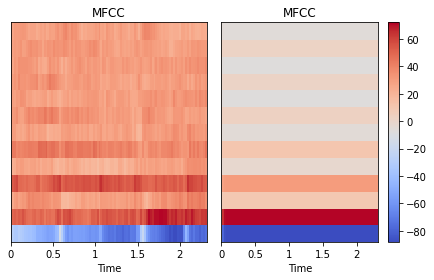

In [52]:
    device = torch.device("cpu")
    checkpoint = torch.load("../data/L1-D196-B20-E100-EXP2/snapshot-3.pytorch", map_location=device)
    test_model = SAMAF(embedding_dim=196)
    test_model.load_state_dict(checkpoint['best_model_weights'])
    test_dataloader = torch.utils.data.DataLoader(SinhalaSongsDataset(root_dir="/home/pasinducw/Downloads/Research-Datasets/Sinhala-Songs/features", trim_seconds=10, test=True), shuffle=True)
    with torch.no_grad():
        _, mfccs = iter(test_dataloader).next()
        embeddings, seq_pred = test_model(mfccs)
        print(mfccs.shape, seq_pred.shape)
        draw_mfccs(mfccs[0, 0], seq_pred[0,0])
#         draw_mfccs(mfccs[0,1], seq_pred[0,1])

In [ ]:
a = torch.randn(3,3)
b = lambda v: v if 0 <= v <= 0.55 else 0
c = torch.vmap(b)